# Content Classification with Logistic Regression

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.utils import save_model, load_model

## Import Data

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,content,label
0,"Liputan6.com, London - Lee Dixon khawatir Arse...",bola
1,"Liputan6.com, Jakarta - Kasus dugaan penganiay...",news
2,"Liputan6.com, Jakarta Menanggapi aksi eks peke...",bisnis
3,"Liputan6.com, Medan - Sebanyak 81 kendaraan 4x...",bola
4,"Liputan6.com, Jakarta Indonesia akan melawan T...",bola


In [3]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,content,label
0,"Liputan6.com, Bandung Persib Bandung akan menj...",bola
1,"Liputan6.com, Jakarta - Mantan Ketua Mahkamah ...",news
2,"Liputan6.com, Cardiff - Tragedi yang menimpa E...",bola
3,"Liputan6.com, Jakarta - Kementerian Kelautan d...",bisnis
4,"Liputan6.com, Jakarta - PT Pertamina (Persero)...",bisnis


In [4]:
df_train.shape

(6127, 2)

Data train terdiri dari 6127 baris dan 2 kolom.

In [5]:
df_test.shape

(2627, 2)

Data test terdiri dari 2627 baris dan 2 kolom.

In [6]:
df_train.dtypes

content    object
label      object
dtype: object

In [7]:
df_test.dtypes

content    object
label      object
dtype: object

Tipe data telah sesuai baik pada train dan test.

In [8]:
df_train.isna().sum()

content    0
label      0
dtype: int64

In [9]:
df_test.isna().sum()

content    0
label      0
dtype: int64

Data telah bersih baik pada train dan test.

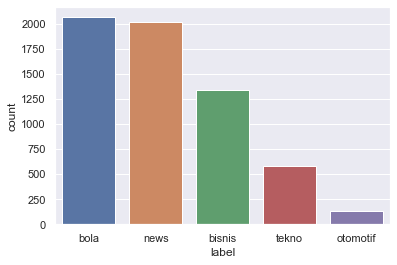

In [10]:
sns.countplot(df_train.label);

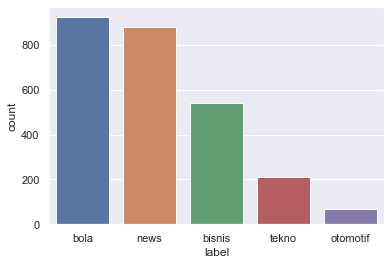

In [11]:
sns.countplot(df_test.label);

Terjadi imbalanced class baik pada train dan test. Maka, kita akan menggunakan f1-score sebagai metric.

In [12]:
df_train.content[0]

'Liputan6.com, London - Lee Dixon khawatir Arsenal tak bisa merekrut Denis Suarez secara permanen musim panas nanti. Pasalnya sejauh ini, Suarez hanya menjadi cadangan bagi The Gunners.\n\nSuarez dipinjam Arsenal dari Barcelona, Januari lalu. The Gunners juga bisa membelinya pada akhir musim nanti jika permainannya memuaskan.\n\nNamun sejauh ini Suarez tak menjadi pilihan utama di Arsenal. Manajer Unai Emery baru memberinya kesempatan bermain selama 85 menit.\n\n"Emery mungkin tahu kualitas Suarez. Dia tahu Suarez pemain yang dibutuhkannya," kata Dixon seperti dilansir Evening Standard.\n\n"Namun dari sudut pandang Suarez, dia pasti berpikir untuk apa pindah kalau tidak bermain. Jadi mungkin saja dia akan menolak Arsenal," katanya menambahkan.'

In [13]:
df_train.content[123]

'Liputan6.com, Jakarta Pasti banyak orang yang bisa menggunakan aplikasi Microsoft Office pada laptop ataupun PC. Namun kebanyakan orang hanya mahir pada Ms. Word saja, padahal aplikasi yang tersedia bukan hanya Ms.Word. Salah satu aplikasi yang mungkin jarang digunakan ialah Microsoft Excel.\n\nHal ini karena banyak yang menganggap menggunakan Microsoft Excel membingungkan dan juga ribet. Tapi Microsoft Excel sendiri memiliki fitur-fitur sendiri yang memudahkan kamu untuk mengolah data.\n\nSelain untuk mengolah data kamu pun bisa mengetahui cara membuat grafik di Excel dengan mudah. Karena dalam pengaturan yang ada kamu bisa mengubah data yang ada ke dalam bentuk grafik.\n\nLangkah-langkah cara membuat grafik di Excel pun tidak merepatkan. Bahkan jika kamu telah memahami cara membuat grafik di Excel, kamu bisa mengubah grafik dalam berbagai tampilan menarik.\n\nJika kamu masih bingung bagaimana cara membuat grafik di Excel, Liputan6.com telah merangkumnya dari berbagai sumber, Jumat (

## Cleaning

In [14]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sw_indo = stopwords.words('indonesian')

Idealnya kita definisikan sendiri stopwords kita tergantung masalah yang sedang dihadapi. Namun, kali ini saya hanya akan menggunakan stopwords indonesia bawaan nltk.

In [15]:
def cleansing(text):
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1 and word.isalnum()]
    word_list = [word for word in word_list if word not in punctuation]
    word_list = [word for word in word_list if word not in sw_indo]
    text = ' '.join(word_list)
    return text

In [16]:
df_train['content'] = df_train.content.apply(cleansing)

In [17]:
df_test['content'] = df_test.content.apply(cleansing)

In [18]:
df_train.head()

,content,label
0,London Lee Dixon khawatir Arsenal merekrut Den...,bola
1,Jakarta Kasus dugaan penganiayaan remaja melib...,news
2,Jakarta Menanggapi aksi eks pekerja PT Freepor...,bisnis
3,Medan Sebanyak 81 kendaraan 4x4 74 motor Medan...,bola
4,Jakarta Indonesia melawan Thailand Final Piala...,bola


In [19]:
df_test.head()

,content,label
0,Bandung Persib Bandung menjalani laga 32 Piala...,bola
1,Jakarta Mantan Ketua Mahkamah Konstitusi MK Ma...,news
2,Cardiff Tragedi menimpa Emiliano Sala manajer ...,bola
3,Jakarta Kementerian Kelautan Perikanan KKP men...,bisnis
4,Jakarta PT Pertamina Persero Petroliam Nasiona...,bisnis


In [20]:
df_train.content[0]

'London Lee Dixon khawatir Arsenal merekrut Denis Suarez permanen musim panas Pasalnya Suarez cadangan The Gunners Suarez dipinjam Arsenal Barcelona Januari The Gunners membelinya musim permainannya memuaskan Namun Suarez pilihan utama Arsenal Manajer Unai Emery memberinya kesempatan bermain 85 menit Emery kualitas Suarez Dia Suarez pemain dibutuhkannya Dixon dilansir Evening Standard Namun sudut pandang Suarez berpikir pindah bermain Jadi menolak Arsenal'

In [21]:
df_train.content[123]

'Jakarta Pasti orang aplikasi Microsoft Office laptop PC Namun kebanyakan orang mahir Word aplikasi tersedia Salah aplikasi jarang Microsoft Excel Hal menganggap Microsoft Excel membingungkan ribet Tapi Microsoft Excel memiliki memudahkan mengolah data Selain mengolah data grafik Excel mudah Karena pengaturan mengubah data bentuk grafik grafik Excel merepatkan Bahkan memahami grafik Excel mengubah grafik tampilan menarik Jika bingung grafik Excel merangkumnya sumber Jumat grafik Excel mudah Berikut grafik Excel ikuti'

## Dataset Splitting

In [22]:
X_train = df_train.content
y_train = df_train.label

X_train.shape, y_train.shape,

((6127,), (6127,))

In [23]:
X_test = df_test.content
y_test = df_test.label

X_test.shape, y_test.shape,

((2627,), (2627,))

## Modeling

In [24]:
from jcopml.tuning import grid_search_params as gsp
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning.space import Integer, Real
from sklearn.linear_model import LogisticRegression

In [25]:
gsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [26]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(min_df=2)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42, multi_class='multinomial'))
])


model = RandomizedSearchCV(pipeline, gsp.logreg_params, cv=10, scoring='f1_macro', n_iter=8, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed:  2.1min finished


{'algo__fit_intercept': True, 'algo__C': 1000.0}
0.9921203347208838 0.9199918538755372 0.9169784843471449


## Class Weight 

In [27]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(min_df=2)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42, multi_class='multinomial'))
])


parameter = {'algo__fit_intercept': [True, False],
             'algo__C': np.logspace(-3, 3, 7),
             'algo__class_weight': [{'bola':0.05, 'news':0.05, 'bisnis':0.05, 'tekno':0.05, 'otomotif':0.8},
                                   {'bola':0.1, 'news':0.1, 'bisnis':0.1, 'tekno':0.1, 'otomotif':0.6}]}


model = RandomizedSearchCV(pipeline, parameter, cv=10, scoring='f1_macro', n_iter=16, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-2)]: Done 160 out of 160 | elapsed:  3.0min finished


{'algo__fit_intercept': False, 'algo__class_weight': {'bola': 0.05, 'news': 0.05, 'bisnis': 0.05, 'tekno': 0.05, 'otomotif': 0.8}, 'algo__C': 1000.0}
0.9921203347208838 0.9225807937471606 0.9231252223923665


## Fine Tuning 

In [28]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(min_df=2)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42, multi_class='multinomial'))
])


parameter = {'algo__fit_intercept': [True, False],
             'algo__C': [700, 800, 900, 1000],
             'algo__class_weight': [{'bola':0.05, 'news':0.05, 'bisnis':0.05, 'tekno':0.05, 'otomotif':0.8}]}


model = RandomizedSearchCV(pipeline, parameter, cv=10, scoring='f1_macro', n_iter=5, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  2.0min finished


{'algo__fit_intercept': False, 'algo__class_weight': {'bola': 0.05, 'news': 0.05, 'bisnis': 0.05, 'tekno': 0.05, 'otomotif': 0.8}, 'algo__C': 900}
0.9921203347208838 0.9228578089980711 0.9234323166960923


Setelah dilakukan classs weight dan fine tuning terjadi sedikit kenaikan pada val dan test.

## Evaluasi 

In [29]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report

In [30]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

      bisnis       1.00      0.99      0.99      1339
        bola       1.00      0.98      0.99      2063
        news       0.97      1.00      0.98      2017
    otomotif       1.00      0.99      1.00       130
       tekno       1.00      0.99      1.00       578

    accuracy                           0.99      6127
   macro avg       0.99      0.99      0.99      6127
weighted avg       0.99      0.99      0.99      6127


Test report
              precision    recall  f1-score   support

      bisnis       0.90      0.90      0.90       542
        bola       0.99      0.98      0.98       923
        news       0.91      0.94      0.93       880
    otomotif       0.92      0.87      0.90        70
       tekno       0.94      0.89      0.91       212

    accuracy                           0.94      2627
   macro avg       0.93      0.91      0.92      2627
weighted avg       0.94      0.94      0.94      26

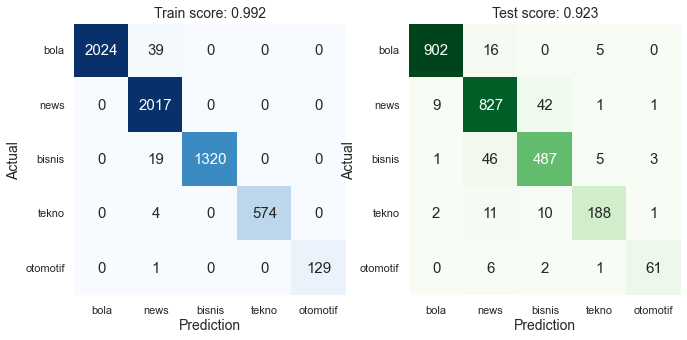

In [31]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

Dari hasil modeling telah mendapatkan hasil yang bagus namun, masih harus diperbaiki lagi karena banyak kesalahan prediksi pada news.

## Check 

In [32]:
text = '''Di Thailand, bengkel motor custom OK Easy Shop berhasil melahirkan street tracker mumpuni  dengan basis Interceptor 650. 
Secara konsep, ubahannya mengarah ke street tracker. Tapi, ada unsur scrambler yang dimasukkan, yakni pada bagian knalpotnya.'''

In [33]:
text = cleansing(text)

In [34]:
model.predict([text])

array(['otomotif'], dtype=object)